```
    _/    _/  _/_/_/  _/       Numerical Simulation Laboratory
   _/_/  _/ _/       _/       Physics Department
  _/  _/_/    _/    _/       Universita' degli Studi di Milano
 _/    _/       _/ _/       Prof. D.E. Galli
_/    _/  _/_/_/  _/_/_/_/ email: Davide.Galli@unimi.it
```

# Lesson 11

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

### Exercise 11.1

In this exercise, we try to fit the function 
$$
f(x)=2x+1
$$
varying the number of epochs, the number of data points and the noise $\sigma$.

In [41]:
def linear_fit(sigma, n_train, n_epochs):
    m = 2. # slope
    b = 1. # intersect
    f = lambda x: m*x + b # f(x)
    
    # Reset seed, so that the networks are evaluated on the
    # same data and start with the same parameters:
    # this way, the comparison between them is more meaningful.
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Generate data
    x_train = np.random.uniform(-1, 1, n_train)
    x_valid = np.random.uniform(-1, 1, n_train // 10)
    x_test = np.random.uniform(-1, 1, n_train // 10)
    x_valid.sort()
    y_target = f(x_valid) # ideal (target) linear function
    y_train = np.random.normal(f(x_train), sigma) # actual measures from which we want to guess regression parameters
    y_valid = np.random.normal(f(x_valid), sigma)
    y_test = np.random.normal(f(x_test), sigma)

    # Plot data
    plt.figure(figsize=(18,6))
    plt.subplot(1, 2, 1)
    plt.grid(True)
    plt.plot(x_valid, y_target, label='Target', c="black")
    plt.scatter(x_train, y_train, label='Data')
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")

    # Build neural network
    model = tf.keras.Sequential()
    model.add(Dense(1, input_shape=(1,)))
    model.compile(optimizer='sgd', loss='mse')
    
    # Train neural network
    history = model.fit(x=x_train, y=y_train, 
        batch_size=32, epochs=n_epochs,
        shuffle=True,                                   # a good idea is to shuffle input before at each epoch
        validation_data=(x_valid, y_valid), verbose=0)
    print("Predicted: y =", model.get_weights()[0][0][0], "* x +", model.get_weights()[1][0])

    # Evaluate neural network
    score = history.history["loss"][-1]  # On training data
    print("Training loss:", score)
    score = history.history["val_loss"][-1]  # On validation data
    print("Validation loss:", score)
    score = model.evaluate(x_test, y_test, batch_size=32, verbose=0)  # On never seen data
    print("Test loss:", score)
   
    # Predict data
    x_predicted = np.random.uniform(-1, 1, 100)
    y_predicted = model.predict(x_predicted)
    #plt.subplot(1, 3, 3)
    #plt.plot(x_valid, y_target)
    plt.scatter(x_predicted, y_predicted, label="Predicted")
    plt.legend()
    #plt.show()
    
    # Plot loss function
    plt.subplot(1, 2, 2)
    plt.grid(True)
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()

At first, we try training the network on data that follows the model exactly, _i.e._ with $\sigma=0$.

Predicted: y = 1.08176 * x + 0.95197994
Training loss: 0.32594433426856995
Validation loss: 0.2666534185409546
Test loss: 0.3520599603652954


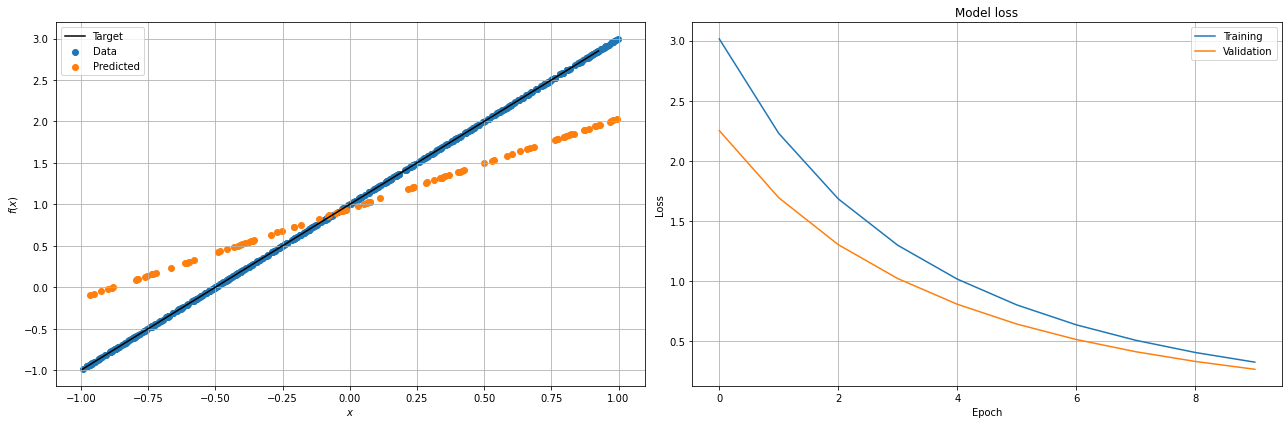

In [42]:
linear_fit(sigma=0., n_train=500, n_epochs=10)

The network didn't learn the parameters properly, so we try at first using more epochs (since we see from the plot that the loss was still decreasing) and then more data.

Predicted: y = 1.8963847 * x + 0.9985881
Training loss: 0.00411927979439497
Validation loss: 0.0034114301670342684
Test loss: 0.00439130375161767


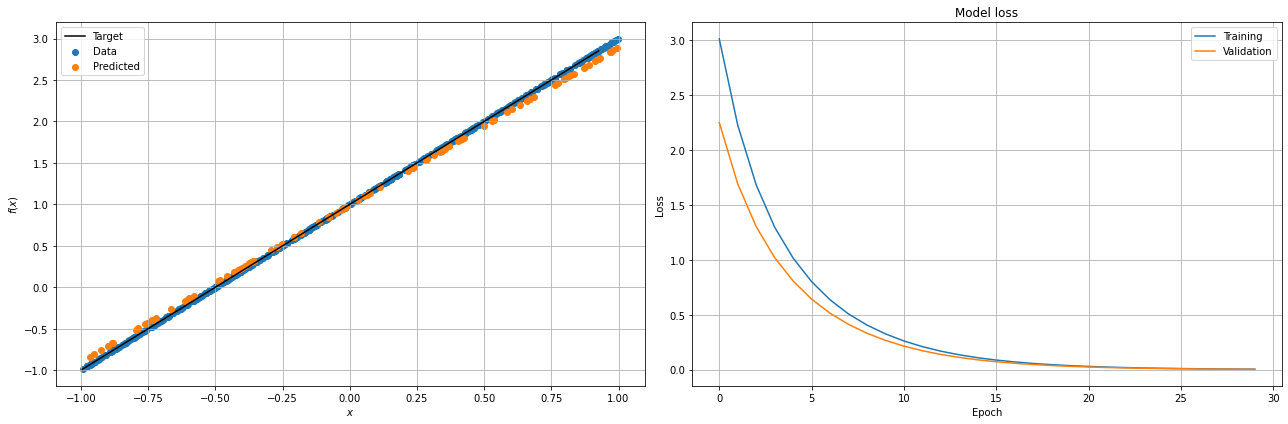

In [43]:
linear_fit(sigma=0., n_train=500, n_epochs=30)

Predicted: y = 1.6860825 * x + 0.9946205
Training loss: 0.042288411408662796
Validation loss: 0.03812340274453163
Test loss: 0.03376461938023567


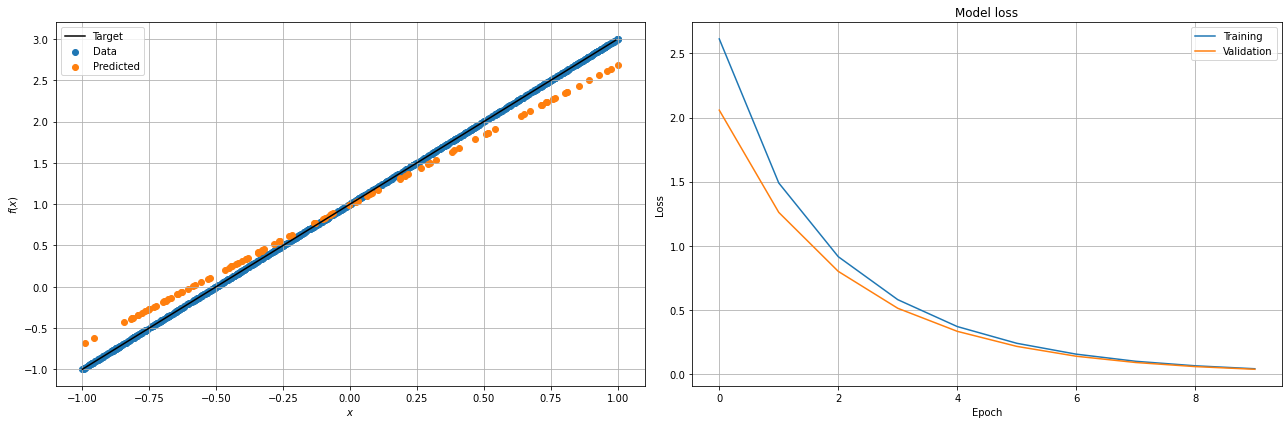

In [44]:
linear_fit(sigma=0., n_train=1000, n_epochs=10)

Finally, since the results have improved but are still different fomr the expected function, we try incrementing both the epochs the data.

Predicted: y = 1.995902 * x + 0.99993896
Training loss: 7.1952558755583595e-06
Validation loss: 6.49877438263502e-06
Test loss: 5.751135176979005e-06


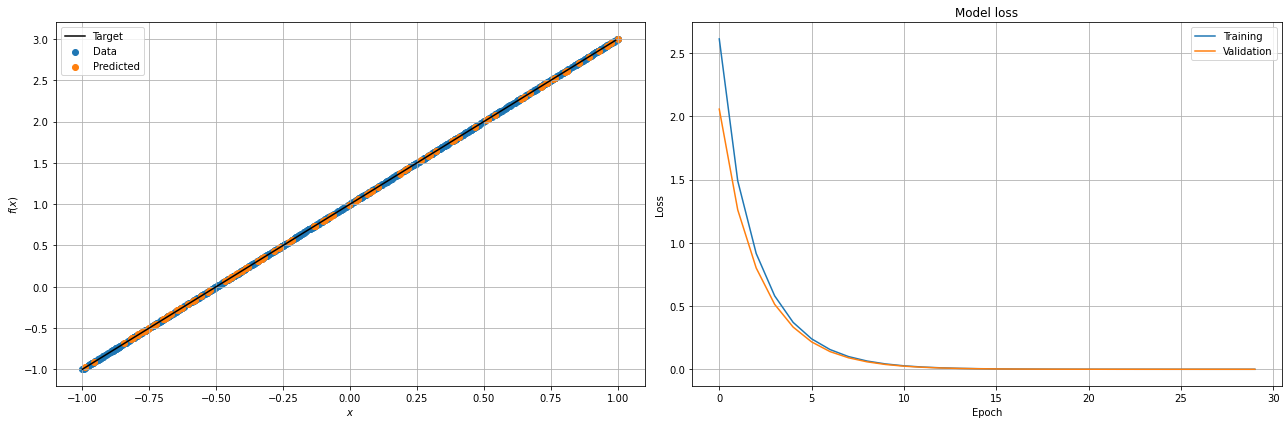

In [45]:
linear_fit(sigma=0., n_train=1000, n_epochs=30)

Now let's generate a set of input data which will slightly deviate from our ideal behaviour using a random noise $\sigma = 1$.

Predicted: y = 1.7968277 * x + 0.9142392
Training loss: 1.0127254724502563
Validation loss: 0.5488293170928955
Test loss: 1.0228817462921143


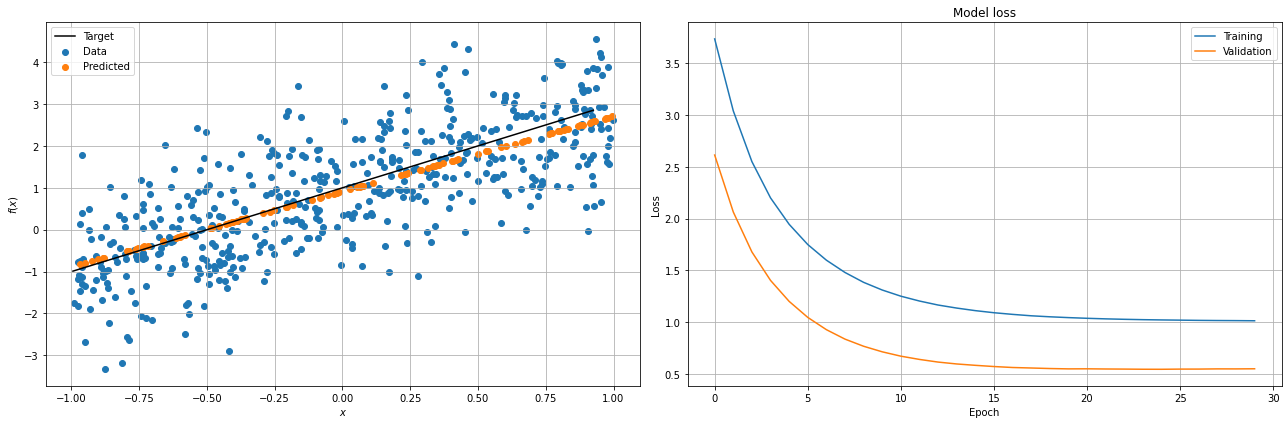

In [46]:
linear_fit(sigma=1., n_train=500, n_epochs=30)

Predicted: y = 2.0295482 * x + 1.0163612
Training loss: 0.9334166646003723
Validation loss: 0.8559761047363281
Test loss: 1.162248969078064


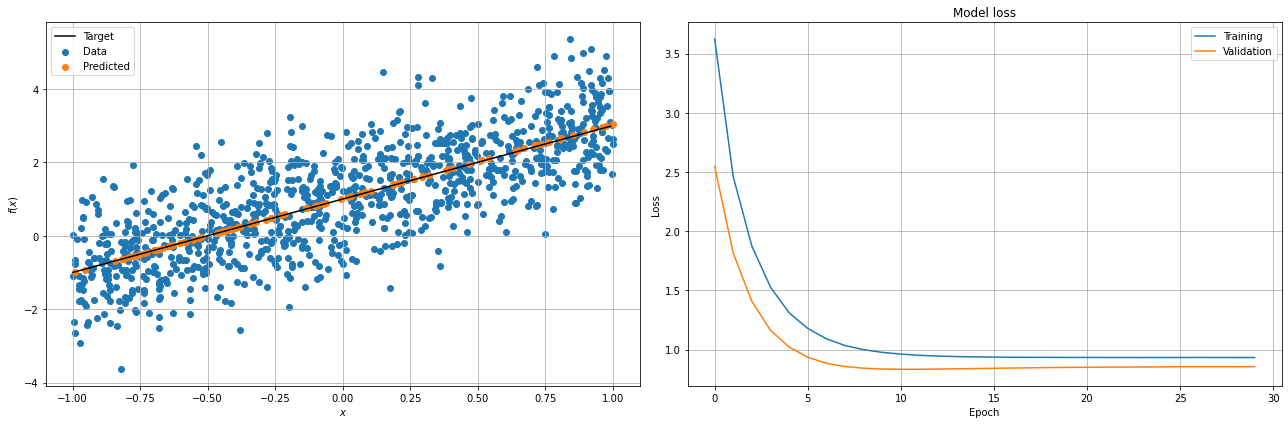

In [47]:
linear_fit(sigma=1., n_train=1000, n_epochs=30)

2𝑥### Exercise 11.2

In this exercise, we try to fit sime data distributed with a gaussian noise $\sigma=1$ around the model

$$
f(x)=4-3x-2x^2+3x^3
$$
for $x \in [-1,1]$.

We try various configurations of:

- the number of layers
- the number of neurons in each layer
- the activation function
- the optimizer
- the loss function

In [146]:
sigma = 1.
n_train = 1000

# Generate data
x_train = np.random.uniform(-1, 1, n_train)
x_valid = np.random.uniform(-1, 1, n_train // 10)
x_test = np.random.uniform(-1, 1, n_train // 10)
x_target = np.linspace(-1.5, 1.5, 1000)
y_target = f(x_target) # ideal (target) linear function
y_train = np.random.normal(f(x_train), sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(f(x_valid), sigma)
y_test = np.random.normal(f(x_test), sigma)

def polynomial_fit(n_layers, n_neurons, activation, optimizer, loss):
    # target parameters of f(x) = a + bx + cx^2 + 3x^3
    a = 4
    b = -3
    c = -2
    d = 3

    f = lambda x: a + b*x + c*x*x + d*x*x*x
    
    # Reset seed, so that the networks are evaluated on the
    # same data and start with the same parameters:
    # this way, the comparison between them is more meaningful.
    np.random.seed(0)
    tf.random.set_seed(0)

    # Plot data
    plt.figure(figsize=(18,6))
    plt.subplot(1, 2, 1)
    plt.grid(True)
    plt.plot(x_target, y_target, label='Target', c="black")
    plt.scatter(x_train, y_train, label='Data')
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")

    # Build neural network
    model = tf.keras.Sequential()
    model.add(Dense(n_neurons, input_shape=(1,), activation=activation))
    for i in range(n_layers - 1):
        model.add(Dense(n_neurons, activation=activation))
    model.add(Dense(1,))
    model.compile(optimizer=optimizer, loss=loss)
    
    # Train neural network
    history = model.fit(x=x_train, y=y_train, 
        batch_size=32, epochs=30,
        shuffle=True,                                   # a good idea is to shuffle input before at each epoch
        validation_data=(x_valid, y_valid), verbose=0)

    # Evaluate neural network
    score = history.history["loss"][-1]  # On training data
    print("Training loss:", score)
    score = history.history["val_loss"][-1]  # On validation data
    print("Validation loss:", score)
    score = model.evaluate(x_test, y_test, batch_size=32, verbose=0)  # On never seen data
    print("Test loss:", score)
   
    # Predict data
    x_predicted = np.random.uniform(-1.5, 1.5, 500)
    y_predicted = model.predict(x_predicted)
    #plt.subplot(1, 3, 3)
    #plt.plot(x_valid, y_target)
    plt.scatter(x_predicted, y_predicted, label="Predicted")
    plt.legend()
    #plt.show()
    
    # Plot loss function
    plt.subplot(1, 2, 2)
    plt.grid(True)
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()

Training loss: 1.4551283121109009
Validation loss: 1.094516396522522
Test loss: 1.472528338432312


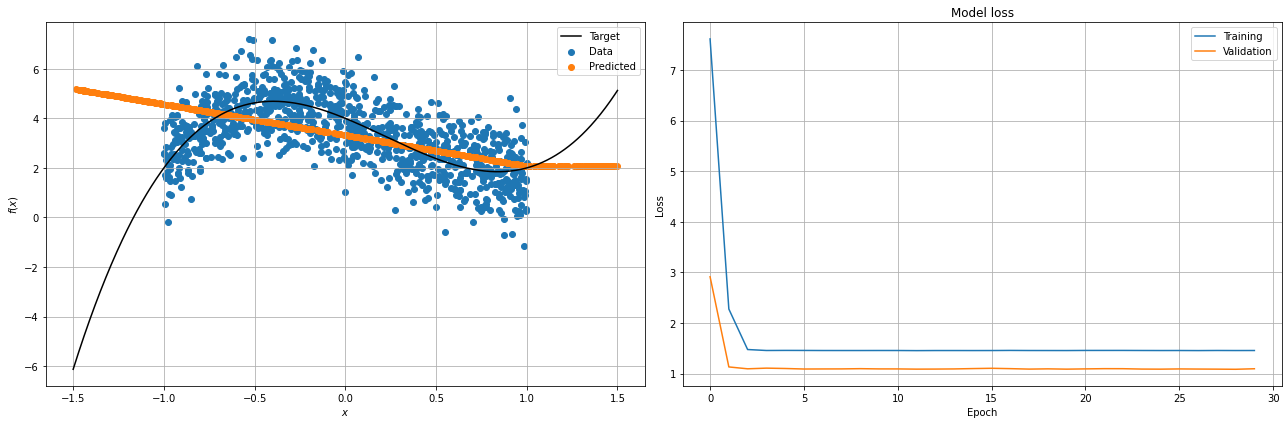

In [147]:
polynomial_fit(n_layers=1, n_neurons=1, activation='relu', optimizer='sgd', loss='mse')

Training loss: 1.0542247295379639
Validation loss: 0.9190990924835205
Test loss: 1.0416618585586548


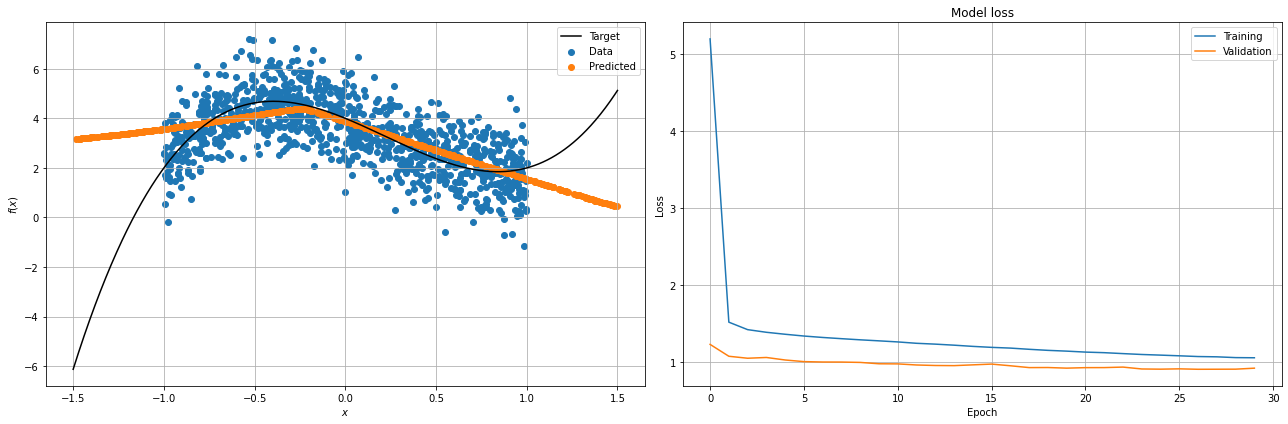

In [148]:
polynomial_fit(n_layers=1, n_neurons=30, activation='relu', optimizer='sgd', loss='mse')

Training loss: 1.2516599893569946
Validation loss: 0.9997899532318115
Test loss: 1.262826919555664


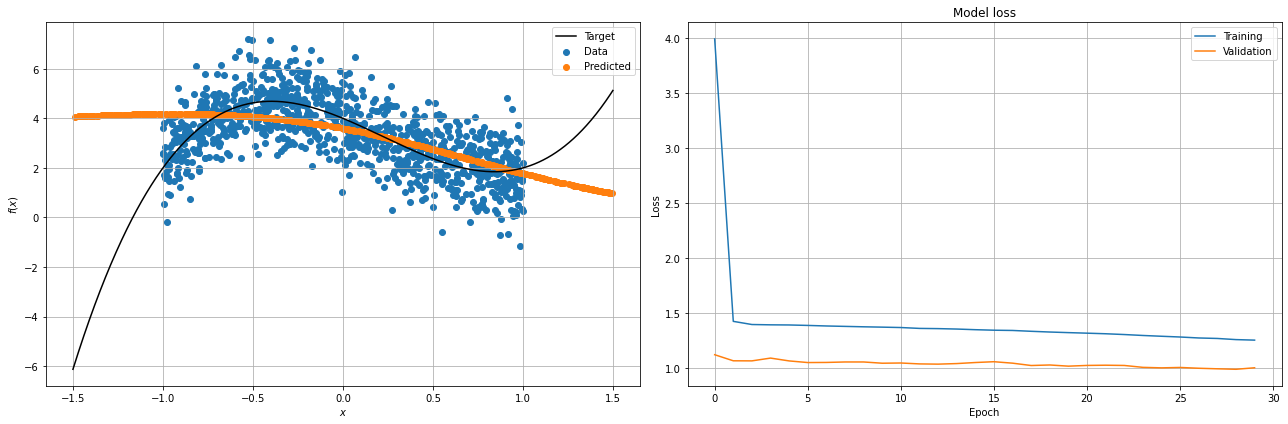

In [149]:
polynomial_fit(n_layers=1, n_neurons=30, activation='tanh', optimizer='sgd', loss='mse')

Training loss: 1.9950686693191528
Validation loss: 1.683520793914795
Test loss: 2.1607770919799805


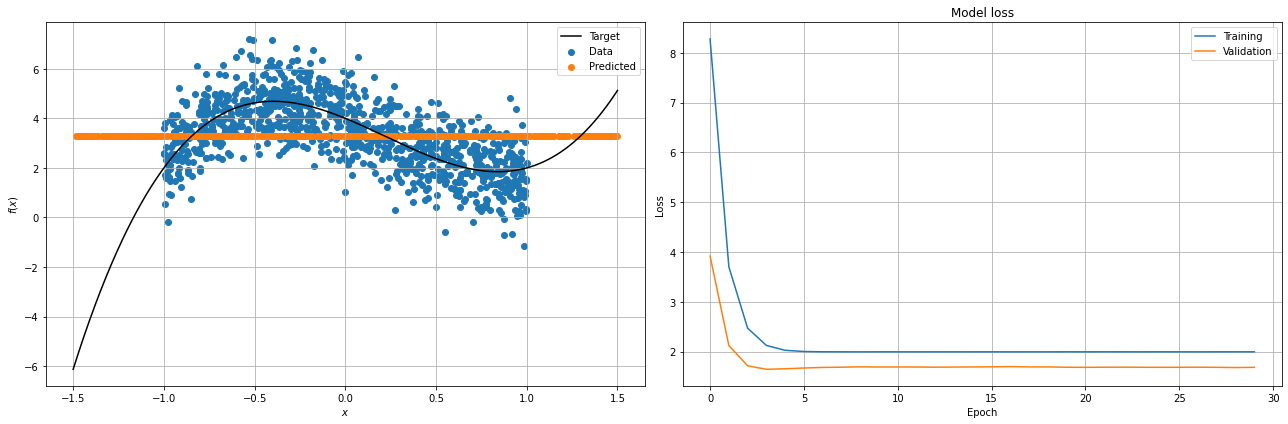

In [127]:
polynomial_fit(n_layers=3, n_neurons=1, activation='relu', optimizer='sgd', loss='mse')

Training loss: 1.0219299793243408
Validation loss: 0.9361286163330078
Test loss: 0.9971705675125122


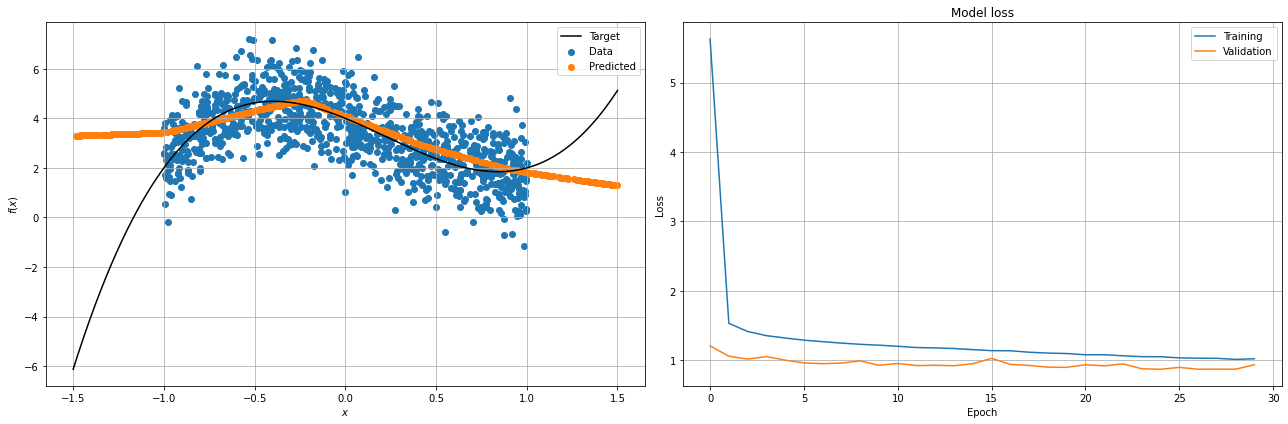

In [128]:
polynomial_fit(n_layers=3, n_neurons=10, activation='relu', optimizer='sgd', loss='mse')

Training loss: 1.9950686693191528
Validation loss: 1.683520793914795
Test loss: 2.1607770919799805


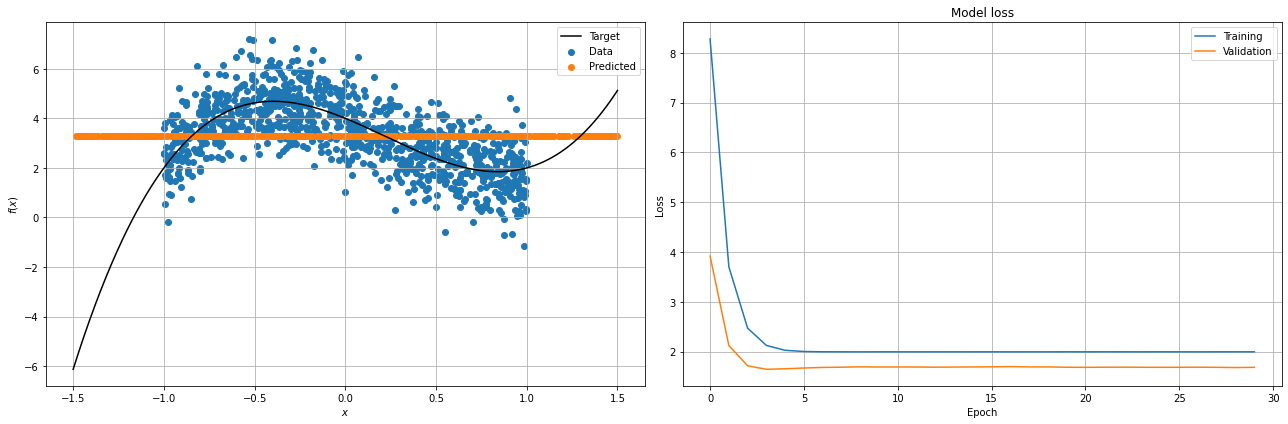

In [129]:
polynomial_fit(n_layers=10, n_neurons=1, activation='relu', optimizer='sgd', loss='mse')

Training loss: 1.1731464862823486
Validation loss: 0.8934051990509033
Test loss: 1.0689009428024292


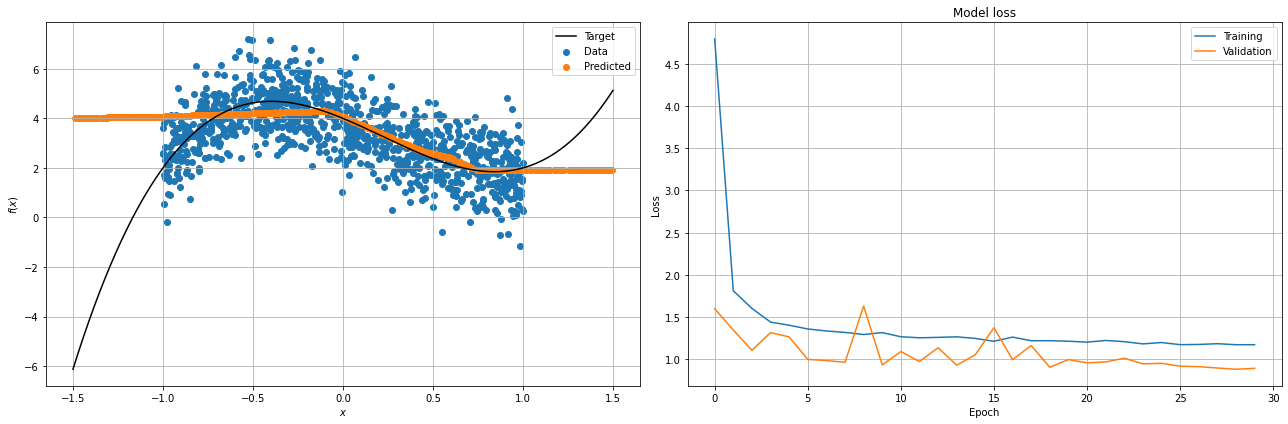

In [130]:
polynomial_fit(n_layers=10, n_neurons=10, activation='relu', optimizer='sgd', loss='mse')

Training loss: 0.9947121143341064
Validation loss: 0.8995649218559265
Test loss: 0.8838054537773132


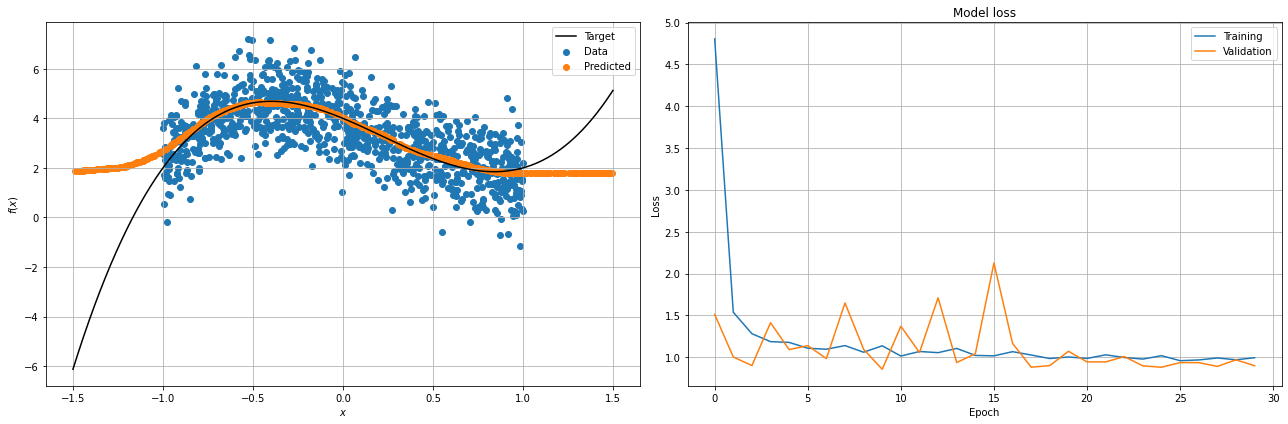

In [131]:
polynomial_fit(n_layers=10, n_neurons=30, activation='relu', optimizer='sgd', loss='mse')

Training loss: 0.9973292350769043
Validation loss: 0.8909324407577515
Test loss: 0.8716284036636353


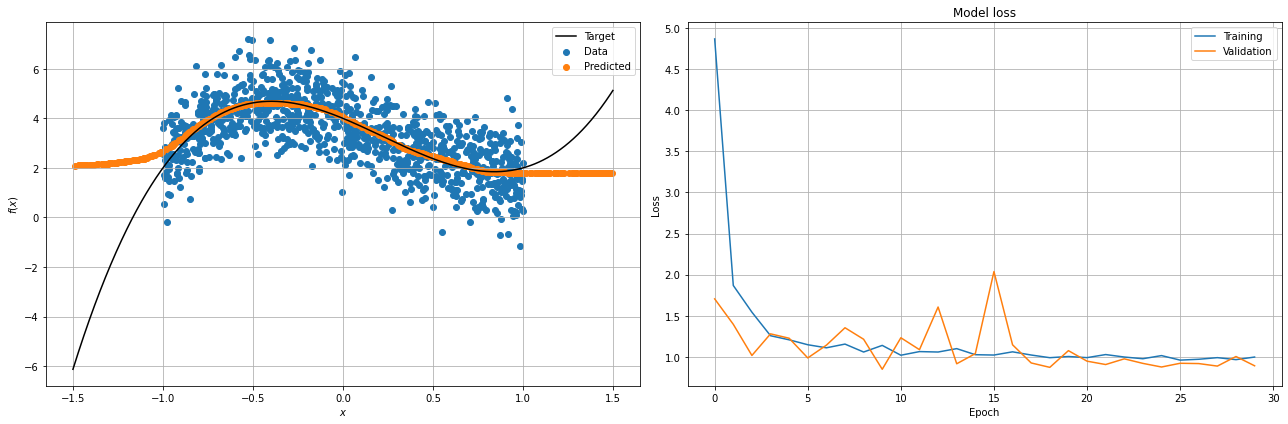

In [150]:
polynomial_fit(n_layers=10, n_neurons=50, activation='relu', optimizer='sgd', loss='mse')

Training loss: 0.7933725714683533
Validation loss: 0.8032713532447815
Test loss: 0.8147465586662292


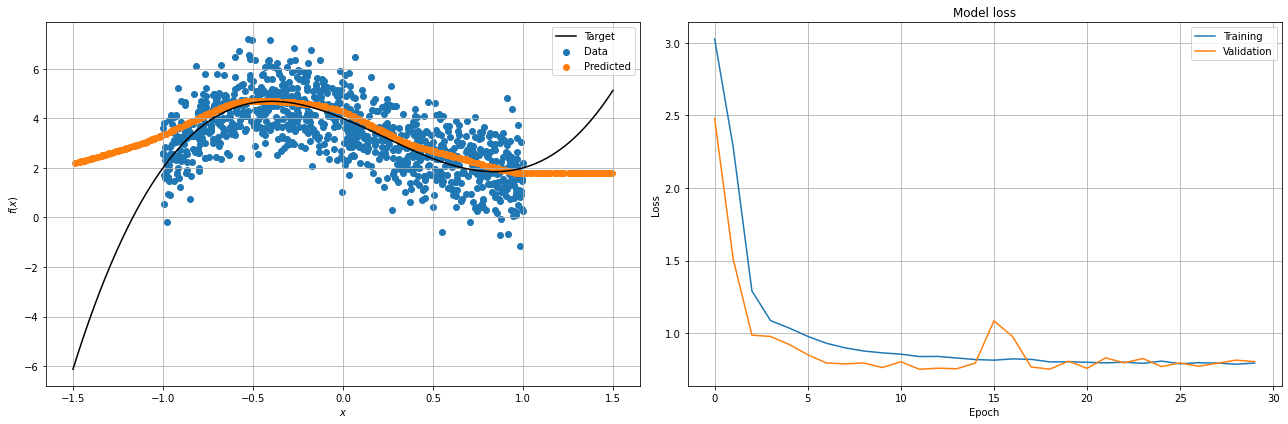

In [132]:
polynomial_fit(n_layers=10, n_neurons=30, activation='relu', optimizer='sgd', loss='mae')

Training loss: 0.9979354739189148
Validation loss: 0.9257733225822449
Test loss: 0.9102652668952942


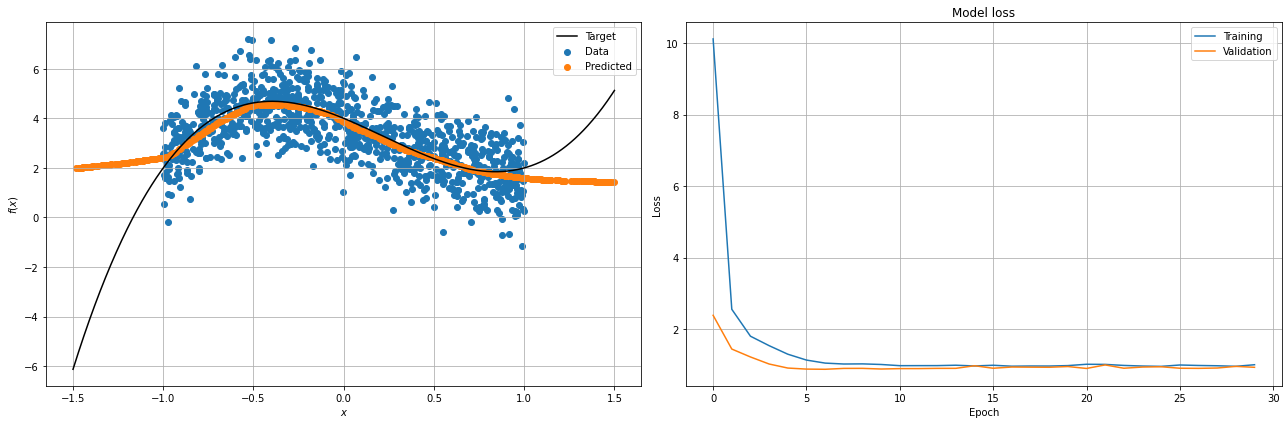

In [133]:
polynomial_fit(n_layers=10, n_neurons=30, activation='relu', optimizer='adam', loss='mse')

Training loss: 0.9974801540374756
Validation loss: 0.9202578067779541
Test loss: 0.8908165693283081


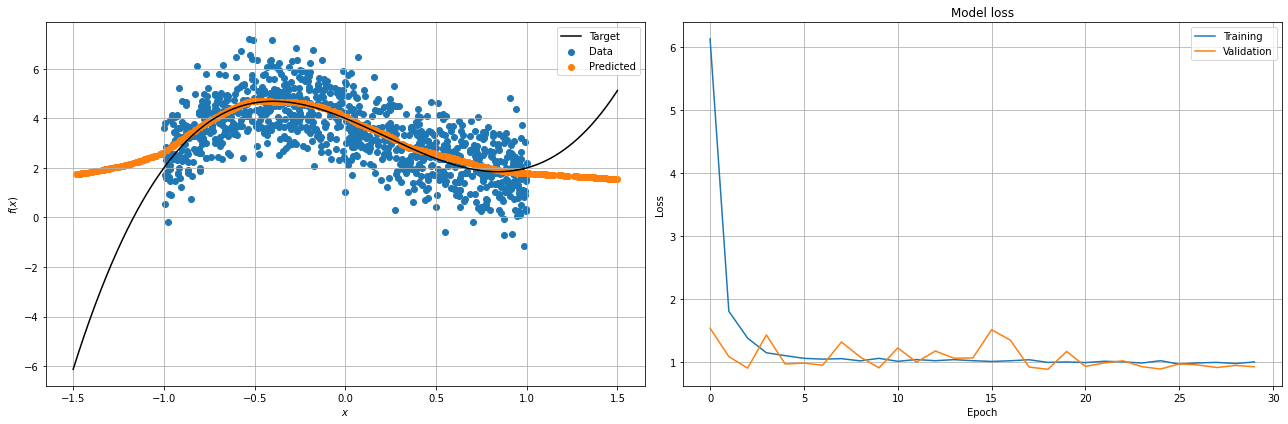

In [160]:
polynomial_fit(n_layers=10, n_neurons=30, activation='relu', optimizer='rmsprop', loss='mse')

Training loss: 1.5046107769012451
Validation loss: 1.087193489074707
Test loss: 1.4841065406799316


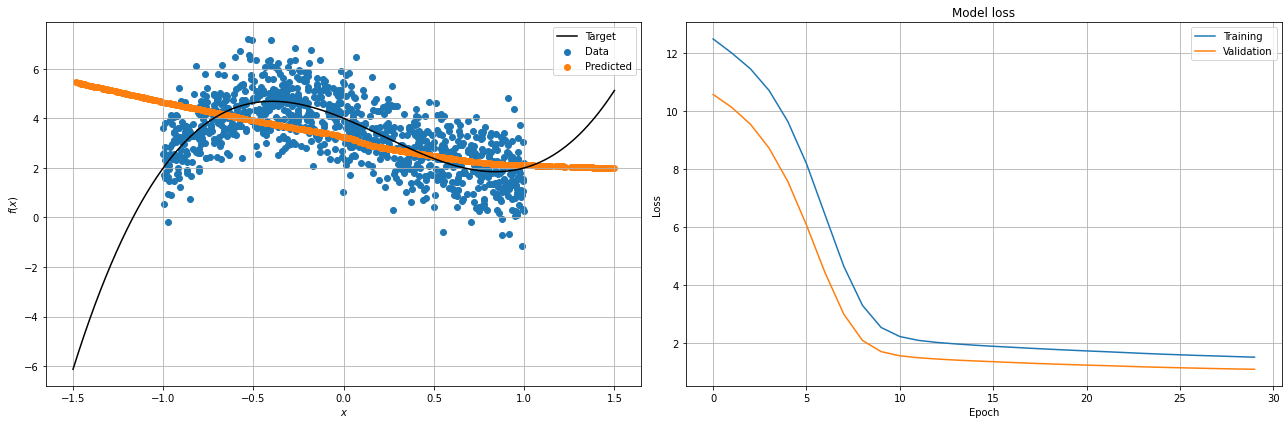

In [161]:
polynomial_fit(n_layers=10, n_neurons=30, activation='relu', optimizer='adagrad', loss='mse')

Training loss: 0.36814627051353455
Validation loss: 0.36128246784210205
Test loss: 0.3623528778553009


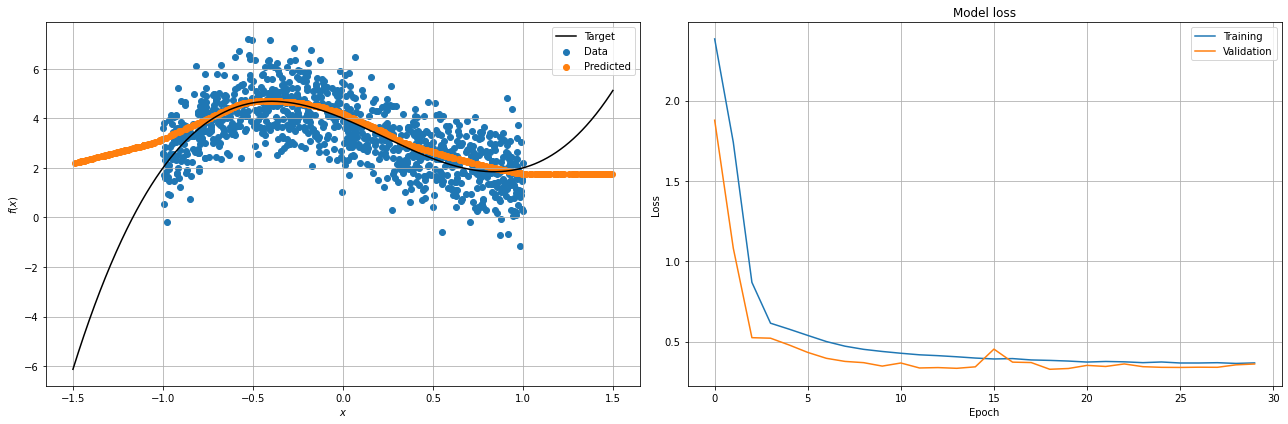

In [162]:
polynomial_fit(n_layers=10, n_neurons=30, activation='relu', optimizer='sgd', loss='log_cosh')

Training loss: 0.09174946695566177
Validation loss: 0.08010565489530563
Test loss: 0.08263847231864929


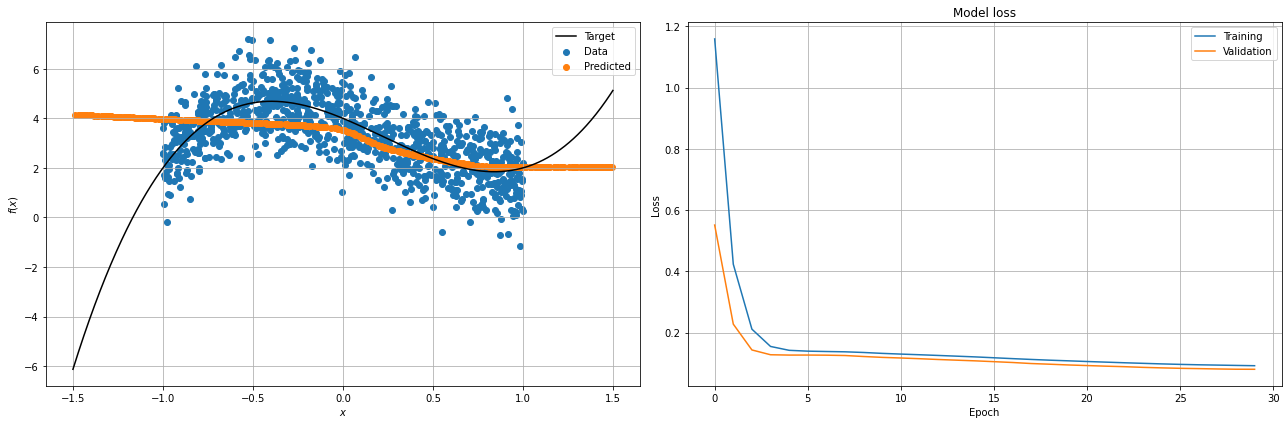

In [158]:
polynomial_fit(n_layers=10, n_neurons=30, activation='relu', optimizer='sgd', loss='mean_squared_logarithmic_error')

Training loss: 66.21107482910156
Validation loss: 91.44467163085938
Test loss: 61.894290924072266


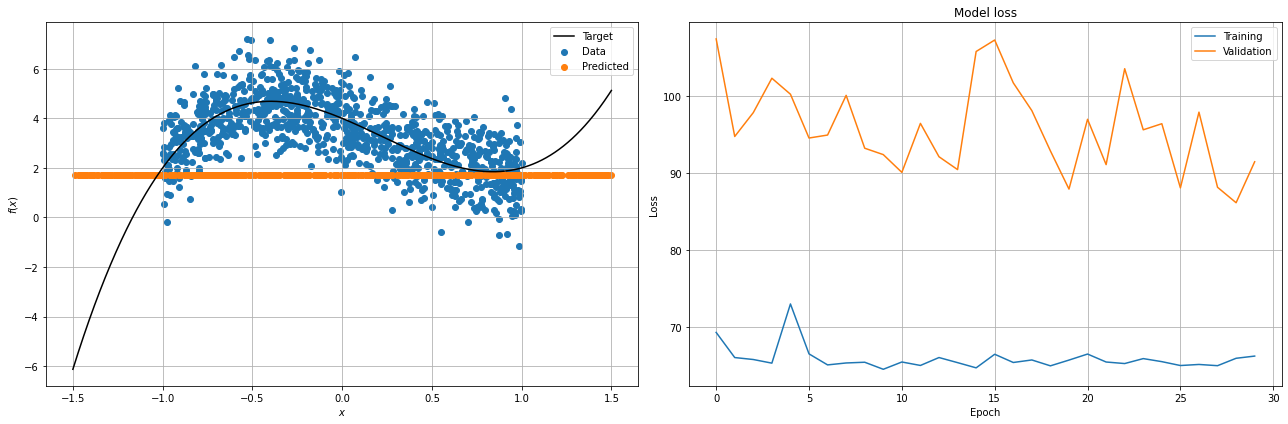

In [159]:
polynomial_fit(n_layers=10, n_neurons=30, activation='relu', optimizer='sgd', loss='mean_absolute_percentage_error')

Training loss: 0.4181491434574127
Validation loss: 0.41716116666793823
Test loss: 0.41594448685646057


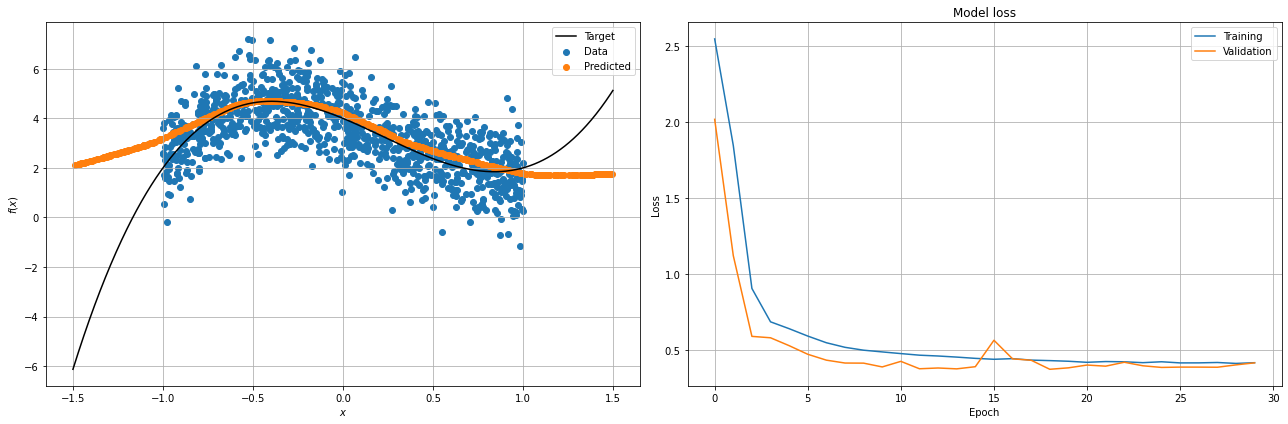

In [154]:
polynomial_fit(n_layers=10, n_neurons=30, activation='relu', optimizer='sgd', loss='huber')

Training loss: 1.0118974447250366
Validation loss: 0.8900531530380249
Test loss: 0.896605372428894


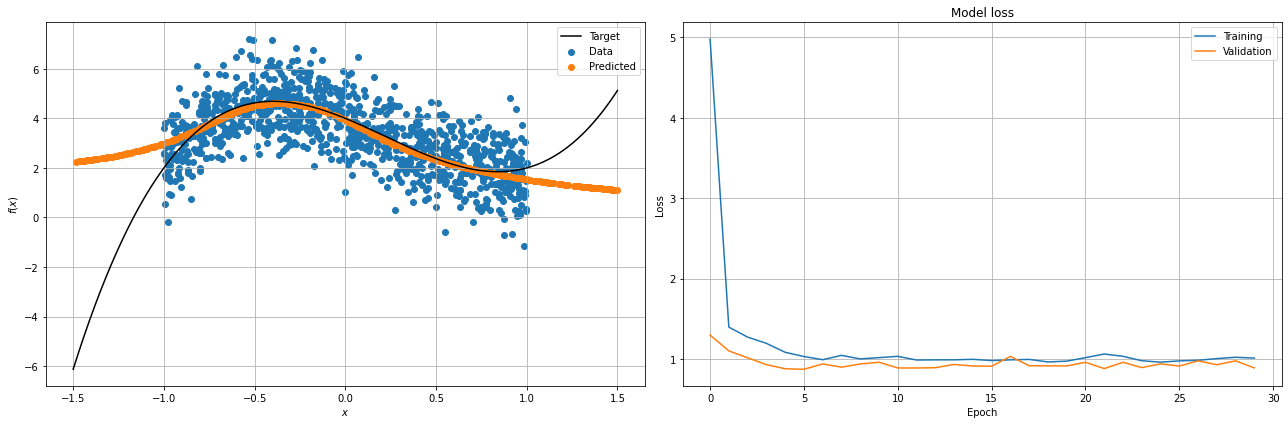

In [142]:
polynomial_fit(n_layers=10, n_neurons=30, activation='tanh', optimizer='adam', loss='mse')

Training loss: 2.031812906265259
Validation loss: 1.6610252857208252
Test loss: 2.1683454513549805


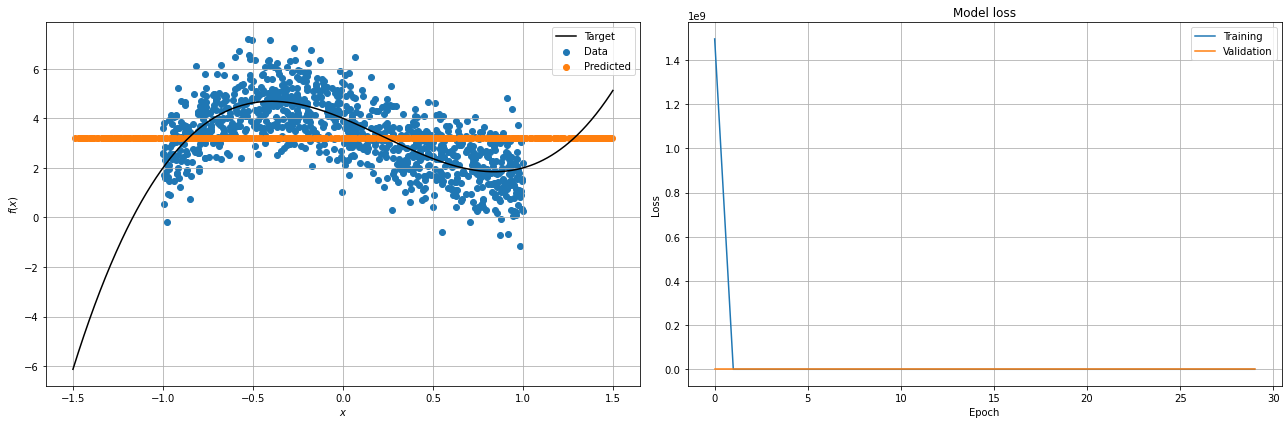

In [144]:
polynomial_fit(n_layers=100, n_neurons=300, activation='relu', optimizer='rmsprop', loss='mse')

Training loss: 2.0131187438964844
Validation loss: 1.6726683378219604
Test loss: 2.1629154682159424


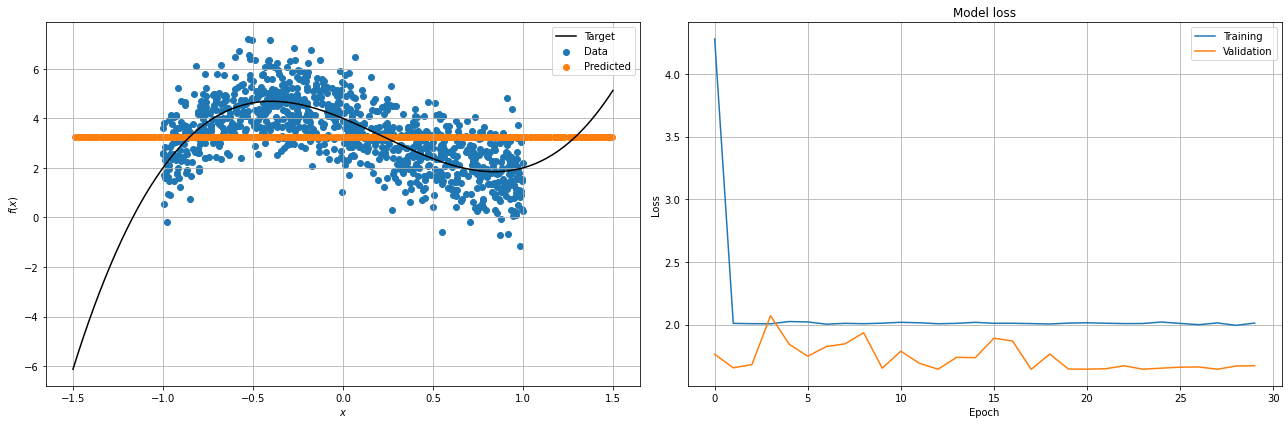

In [145]:
polynomial_fit(n_layers=100, n_neurons=300, activation='relu', optimizer='sgd', loss='mse')

We observe that the network learned to predict models in the $[-1, 1]$ range in some cases, but for no combinations of hyperparameters it predicted well outside it.

We also notice that increasing the complexity does not always result in an improvement: in particular, just increasing the layers without also increasing the number of neurons often gives _worse_ prediction ability to the NN.

Another important point is that some loss functions - such as `mean_squared_logarithmic_error` and `mean_absolute_percentage_error` - seem not to be suited for our model, and lead to bad predictions.

All the tested optimizers worked quite well except for `adagrad`, and there was no significant difference between using `relu` and `tanh` activation functions.

Finally, the oversized networks with 100 layers and 300 neurons predicted a simple linear function, confirming that complexity does not always lead to better predictions.

### Exercise 11.3
  
In this exercise we try to extend the model to fit $f(x,y) = \sin(x^2+y^2)$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

In [228]:
f = lambda x: np.sin(x[:,0]*x[:,0] + x[:,1]*x[:,1])

# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-3/2, 3/2, (10000, 2))
x_valid = np.random.uniform(-3/2, 3/2, (1000, 2))
x_valid.sort()
y_target = f(x_valid) # ideal (target) function

sigma = 1. # noise standard deviation
y_train = np.random.normal(f(x_train), sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(f(x_valid), sigma)

In [229]:
model = tf.keras.Sequential()
model.add(Dense(30, input_shape=(2,), activation="relu"))
model.add(Dense(30, activation="relu"))
model.add(Dense(30, activation="relu"))
model.add(Dense(30, activation="relu"))
model.add(Dense(30, activation="relu"))
model.add(Dense(30, activation="relu"))
model.add(Dense(30, activation="relu"))
model.add(Dense(1,))

model.compile(optimizer='adam', loss='mse')

history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=50, shuffle=True,
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.005, verbose=0, mode='auto')],
          validation_data=(x_valid, y_valid), verbose=0)

Validation loss: 1.0168178081512451
Test loss: 0.051952555775642395


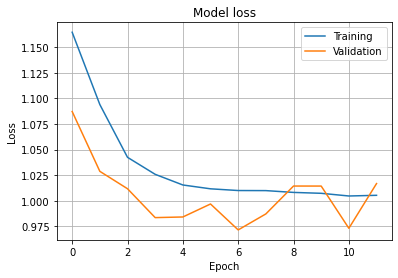

In [230]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=0)
print('Validation loss:', score)

# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=0)
print('Test loss:', score)

# Plot training & validation loss values
plt.grid(True)
plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="Validation")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

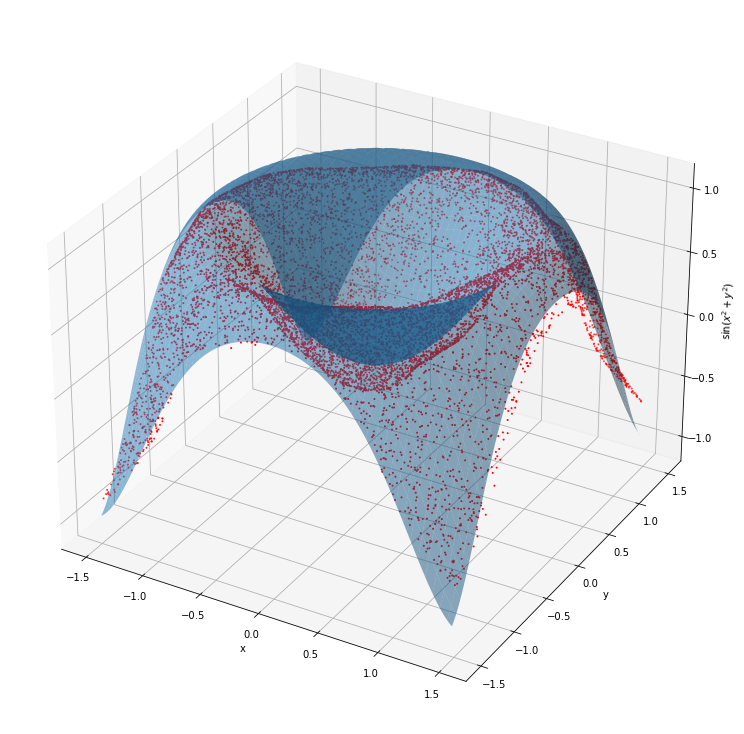

In [231]:
x_predicted = np.random.uniform(-3/2, 3/2, (10000, 2))
y_predicted = model.predict(x_predicted)

X = np.arange(-3./2., 3./2., 0.02)
Y = np.arange(-3./2., 3./2., 0.02)
X, Y = np.meshgrid(X, Y)
R = X**2 + Y**2
Z = np.sin(R)

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('sin($x^2+y^2$)')

surf = ax.plot_surface(X, Y, Z, alpha=0.5, linewidth=0, antialiased=True)
ax.scatter(x_predicted[:, 0], x_predicted[:, 1], y_predicted, color='r', marker='o', s=1)

plt.show()